In [ ]:
# Import and mount drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def load_amazon_reviews(csv_folder, max_reviews=500000000):
    reviews = []
    total_loaded = 0

    # List all CSV files in the folder with a f for f in os.listdir(csv_folder) -> we create a list of the filenames in our drive direcotry
    files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

    # for file in files
    for file in files:
        if file != ' ':
            # Join the '/content/drive/MyDrive/AmazonReviews' with the individual file name, file
            file_path = os.path.join(csv_folder, file)

            for chunk in pd.read_csv(file_path, chunksize=1000000):
                reviews.append(chunk)
                total_loaded += len(chunk)
                print(f"Loaded {total_loaded} reviews so far.")

                if total_loaded >= max_reviews:
                    break

    # Concatenate all chunks into a single DataFrame
    amazon_reviews = pd.concat(reviews)

    return amazon_reviews

In [ ]:
csv_folder = '/content/drive/MyDrive/AmazonReviews'
df_review = load_amazon_reviews(csv_folder)

In [ ]:
import pandas as pd
df_meta = pd.read_csv("df_meta.csv")

<ipython-input-2-d9fad341d634>:2: DtypeWarning: Columns (6,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv("df_meta.csv")


In [ ]:
df_meta['title'] = df_meta['title'].astype(str)
df_meta['main_category'] = df_meta['main_category'].astype(str)
df_meta['details'] = df_meta['details'].astype(str)

In [ ]:
# Preprocess the Kaggle Amazon Dataset
import re

def clean_text(text):
    text = re.sub(r"http/S+", "", text) # Remove URLs
    text = re.sub(r"[^a-zA-z0-9\s]", "", text) # Remove special characters

    # Remove [\ ]
    text = re.sub(r"\[", "", text)
    text = re.sub(r"\]", "", text)
    text = re.sub(r"\{", "", text)
    text = re.sub(r"\}", "", text)
    text = text.lower().strip() # Convert to lowercase and remove unnecessary spaces
    return text

df_meta['title'] = df_meta['title'].apply(clean_text)
df_meta['main_category'] = df_meta['main_category'].apply(clean_text)
# Remove & from main_category via re.sub
df_meta['main_category'] = df_meta['main_category'].apply(lambda x: re.sub(r"&", "", x))
df_meta['details'] = df_meta['details'].apply(clean_text)

In [ ]:
df_meta.head()

main_category                                              title  \
0    all beauty  lurrose 100pcs full cover fake toenails artifi...   
1    all beauty                         gold extatic musk edt 90ml   
2    all beauty  biomiracle stardust pixie bubble mask clarifyi...   
3    all beauty  virochemistry pheromones for women elixir  ele...   
4    all beauty  garnier fructis color sealer instant lightweig...   

   average_rating  rating_number  \
0             3.7           35.0   
1             3.7            2.0   
2             4.4           52.0   
3             3.7           33.0   
4             4.4           17.0   

                                            features  \
0  ['The false toenails are durable with perfect ...   
1  ['Extatic Balmain Gold Musk By Balmain Edt Spr...   
2  ['GENTLE ON THE SKIN - This bubble face mask c...   
3  ['🗽 SCIENTIFICALLY PROVEN! Scientifically Form...   
4  ['Seals In Color And Conditions For Extra Soft...   

                                         description  price  \
0  ['Description', 'The false toenails are durabl...   6.99   
1           ['Edt spray 3 oz design house: balmain']  86.95   
2  ["This foaming pixie sheet mask is infused wit...   5.99   
3  ['The Most Amazingly Effective and Fantastic S...   29.8   
4  ['Proven to stop dry-out. Fight fade-out. The ...   24.0   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   
1  {'hi_res': ['https://m.media-amazon.com/images...   
2  {'hi_res': ['https://m.media-amazon.com/images...   
3  {'hi_res': ['https://m.media-amazon.com/images...   
4  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos          store  \
0            {'title': [], 'url': [], 'user_id': []}        Lurrose   
1            {'title': [], 'url': [], 'user_id': []}        Balmain   
2            {'title': [], 'url': [], 'user_id': []}     BioMiracle   
3  {'title': ['VIROCHEMISTRY Pheromone Perfume To...  VIROCHEMISTRY   
4            {'title': [], 'url': [], 'user_id': []}        Garnier   

  categories                                            details parent_asin  \
0         []  color as shown size large material acrylonitri...  B07G9GWFSM   
1         []  brand balmain item form spray item volume 90 m...  B01ERJEGS6   
2         []  brand biomiracle item form sheet product benef...  B08X7JHQG5   
3         []  brand virochemistry item form liquid item volu...  B07X1TK3VS   
4         []  is discontinued by manufacturer no product dim...  B004ZWH3XG   

   bought_together subtitle author  
0              NaN      NaN    NaN  
1              NaN      NaN    NaN  
2              NaN      NaN    NaN  
3              NaN      NaN    NaN  
4              NaN      NaN    NaN

## **EDA, Prophet Time-Series Forecasting, XGBoost model**

**Average Rating of df_meta by Store (color)**

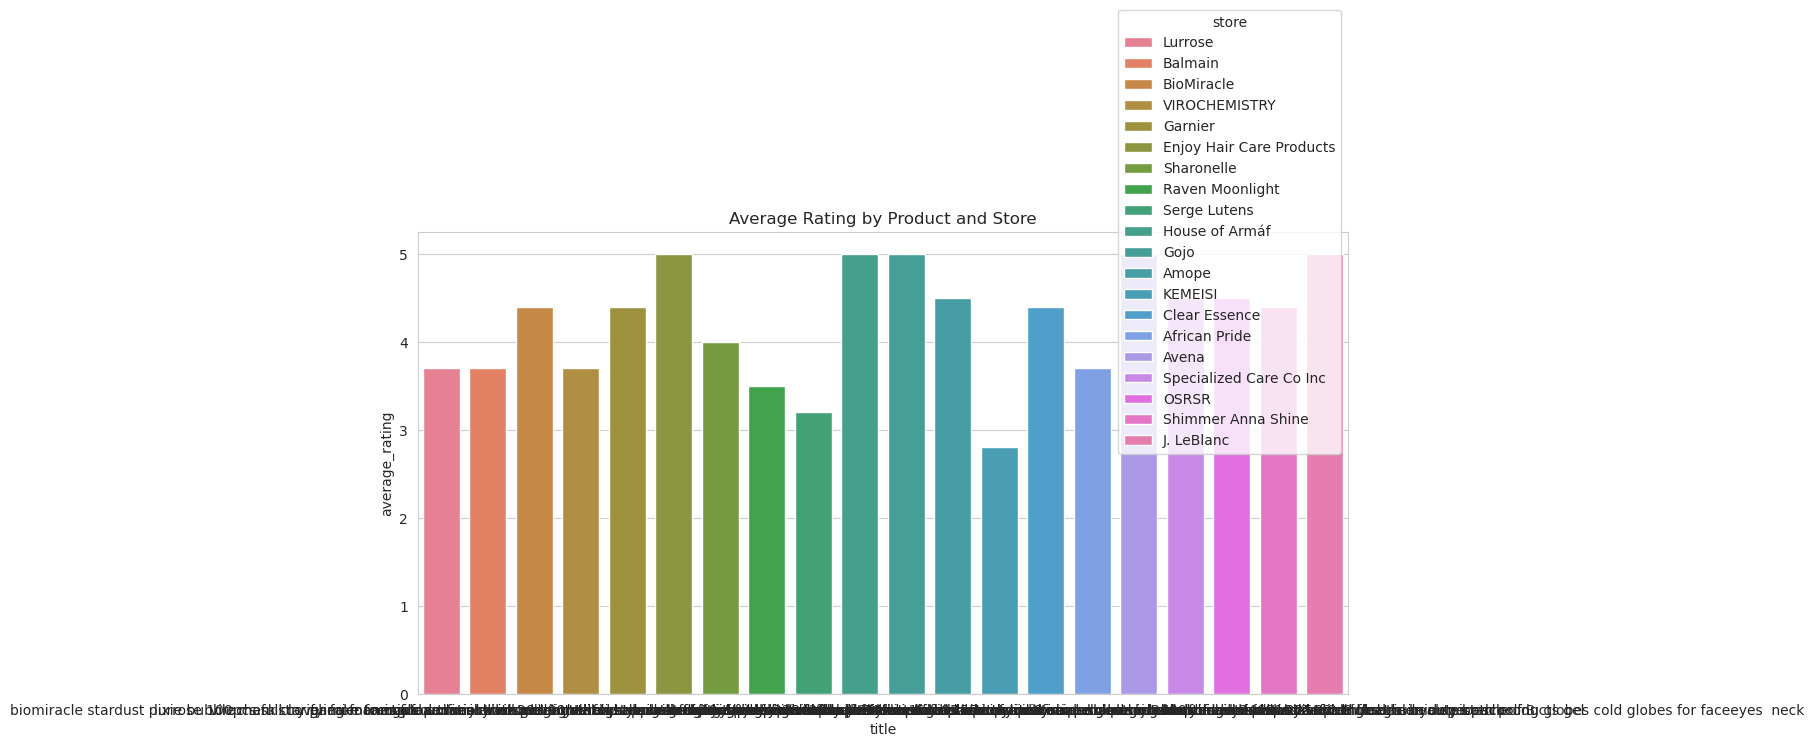

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=df_meta, x=df_meta['title'][0:20], y=df_meta['average_rating'][0:20], hue=df_meta['store'][0:20])
plt.title('Average Rating by Product and Store')
sns.move_legend(plt.gca(), "right", bbox_to_anchor=(1, 1))

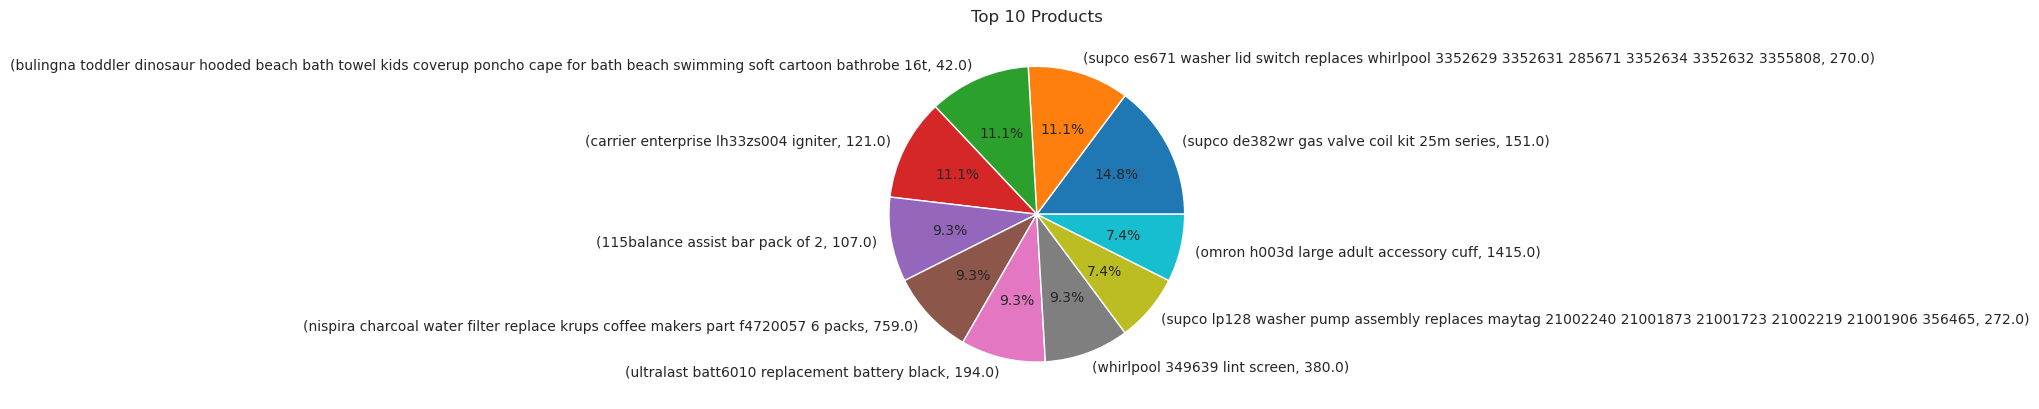

In [ ]:
df_meta[['title', 'rating_number']].value_counts().head(10).plot.pie(autopct='%1.1f%%')
plt.title('Top 10 Products')
plt.ylabel('')
plt.show()

**Seaborn boxplot of price by category**

In [ ]:
df_meta.sort_values(by='price')

main_category                                              title  \
408771     Buy a Kindle  pilot checklist cessna skyhawk c172 sp nav iii...   
347103     Buy a Kindle  electronic projects revisited building wideban...   
338925     Buy a Kindle    mechanical keyboards buying your first keyboard   
242454  All Electronics    dynex ear bud headphones for apple ipod shuffle   
58648       Amazon Home  cremebruluee portable accurate durable analog ...   
...                 ...                                                ...   
256837            Books     winters origin winter black series the prequel   
360432            Books  archeological anomalies graphic artifacts 1  c...   
297578            Books                                  the righteous way   
388309            Books                         linenlook pattern black lg   
317047            Books  mighty bright 35011 baby bright light blue air...   

        average_rating  rating_number  \
408771             4.1            7.0   
347103             4.0           10.0   
338925             4.3           30.0   
242454             1.0            1.0   
58648              5.0            1.0   
...                ...            ...   
256837             4.6            4.0   
360432             5.0            2.0   
297578             4.9           25.0   
388309             4.7            4.0   
317047             3.9           10.0   

                                                 features  \
408771  ['This checklist was specifically written for ...   
347103  ["Learn how to build inexpensive, wide-band VH...   
338925  ["Are you in need of a new computer keyboard? ...   
242454                                                 []   
58648                                                  []   
...                                                   ...   
256837                                                 []   
360432  ['All our books are brand new from the distrib...   
297578  ['In his debut release, The Righteous Way, Sta...   
388309  ['Featuring a linen-look fabric construction, ...   
317047     ['Blue airplane. Flexible neck & sturdy grip']   

                                              description price  \
408771                                                 []   0.0   
347103                                                 []   0.0   
338925                                                 []   0.0   
242454                  ['Great match for IPod Shuffle.']  0.01   
58648   ['Features:', 'Portable size, easy to use and ...  0.01   
...                                                   ...   ...   
256837                                                 []     —   
360432                                                 []     —   
297578  ['Review', "From Hip-Hop's humble foundation, ...     —   
388309  ['From the Back Cover', 'Featuring a linen-loo...     —   
317047                                                 []     —   

                                                   images  \
408771  {'hi_res': [None], 'large': ['https://m.media-...   
347103  {'hi_res': [None], 'large': ['https://m.media-...   
338925  {'hi_res': [None], 'large': ['https://m.media-...   
242454  {'hi_res': [None, None], 'large': ['https://m....   
58648   {'hi_res': ['https://m.media-amazon.com/images...   
...                                                   ...   
256837  {'hi_res': [None], 'large': ['https://m.media-...   
360432  {'hi_res': [None], 'large': ['https://m.media-...   
297578  {'hi_res': [None], 'large': ['https://m.media-...   
388309  {'hi_res': [None], 'large': ['https://m.media-...   
317047  {'hi_res': [None], 'large': ['https://m.media-...   

                                         videos  \
408771  {'title': [], 'url': [], 'user_id': []}   
347103  {'title': [], 'url': [], 'user_id': []}   
338925  {'title': [], 'url': [], 'user_id': []}   
242454  {'title': [], 'url': [], 'user_id': []}   
58648   {'title': [], 'url': [], 'user_id': []}   
...

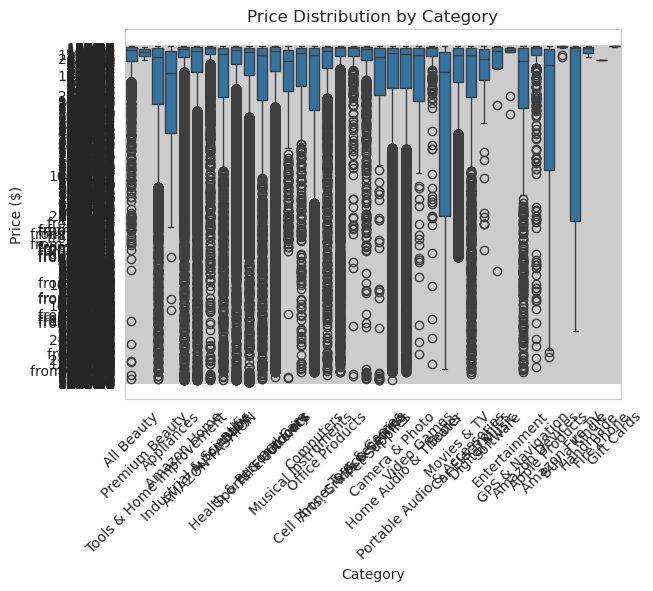

In [ ]:
sns.boxplot(x=df_meta['main_category'], y=df_meta['price'])
plt.title('Price Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.show()

**Product Ratings and Reviews Correlation**

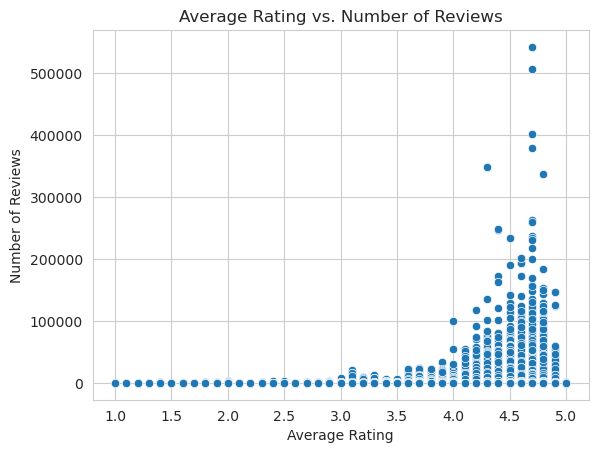

In [ ]:
sns.scatterplot(x='average_rating', y='rating_number', data=df_meta)
plt.title('Average Rating vs. Number of Reviews')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.show()

**Reviews with an average rating between 4.25 and 4.75 have the highest number of reviews**

**Hexbin plot of Average Rating vs. Number of Reviews**

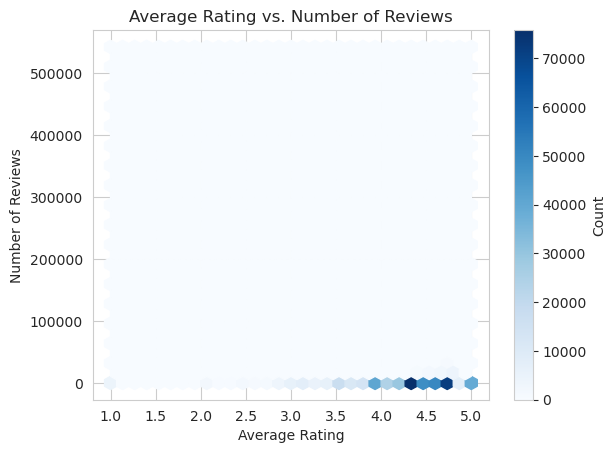

In [ ]:
plt.hexbin(df_meta['average_rating'], df_meta['rating_number'], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Average Rating vs. Number of Reviews')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.show()

**Average Price by Store**

In [ ]:
# Create a function to remove strings from df_price
def clean_price(price):
    if isinstance(price, (int, float)):     # Use the isinstance to check for int, floats in price
        return price

    if not isinstance(price, str):
        return None

    # remove common text patterns
    price = price.lower().replace('from', '').replace('usd', '').replace('$', '')

    # Keep only digits, decimal points
    price = ''.join(char for char in price if char.isdigit() or char in '.-')

    # Try to conver to float
    try:
        return float(price)
    except (ValueError, TypeError):
        return None

# Apply the cleaning function and convert to float
df_meta['price'] = df_meta['price'].apply(clean_price)

In [ ]:
df_meta_top_20_features = df_meta['features'].value_counts().head(20)
df_meta_top_20_features_price = df_meta.groupby('features')['price'].mean()[df_meta_top_20_features.index]

In [ ]:
df_meta_top_20_features_price[1]

22.439275362318842

In [ ]:
df_meta_top_20_features.shape

(20,)

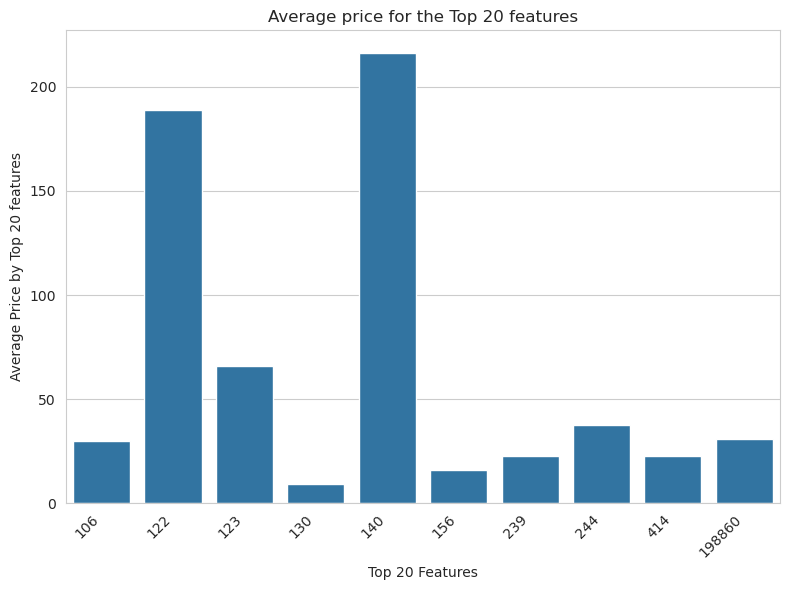

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=df_meta['features'].value_counts().head(10), y=df_meta_top_20_features_price[0:10], data=df_meta)
plt.title('Average price for the Top 20 features')
plt.xlabel('Top 20 Features')
plt.ylabel('Average Price by Top 20 features')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [ ]:
# Top 10 Features by name
df_meta.iloc[df_meta['features'].value_counts().head(10)]

main_category                                              title  \
198860   Movies & TV                       minna  emergency workout vhs   
414       All Beauty  dnd dc 100 pure soak off gel  all in one  nail...   
244       All Beauty  hed  maximum keratin smooth treatment softens ...   
239       All Beauty  tenscare nailit  laser unit to improve appeare...   
156       All Beauty  the crayon case box of crayons 18pan eyeshadow...   
140       All Beauty  boqq 2 pcs organic gray reverse shampoo bar es...   
130       All Beauty  reusable shower cap for women  leakproof nonsl...   
123       All Beauty  simple kind to skin refreshing shower gel 500 ...   
122       All Beauty  commodity gin eau de parfum spray unisex 34 oz...   
106       All Beauty  exolgo tendresse waterproof eyeliner  2 in 1 s...   

        average_rating  rating_number  \
198860             4.5          106.0   
414                5.0            2.0   
244                3.3            6.0   
239                3.5           22.0   
156                4.0           13.0   
140                3.1           45.0   
130                4.5         1210.0   
123                4.6          420.0   
122                3.0            1.0   
106                3.5           17.0   

                                                 features  \
198860                                                 []   
414                                                    []   
244                                                    []   
239     ['IMPORVE APPEARENCE: helps to improve the app...   
156                                                    []   
140     ['【100% organic and natural】: Pure natural pla...   
130     ['DON’T RISK RUINING YOUR HAIRSTYLE with LEAKY...   
123                                                    []   
122                                                    []   
106     ['ACHIEVE THAT PROFESSIONAL LOOK: This eyeline...   

                                              description   price  \
198860  ['Amazon.com', '"Lose weight and tone your bod...    9.99   
414     ['DND DC 100% Pure Soak Off Gel - All in One -...   13.95   
244     ['For Professional Salons Only! We take scienc...  295.00   
239                                                    []   99.90   
156     ["The shadows in this set boast beautiful vibr...   42.20   
140     ['Why Shampoo Bar? Conventional shampoos are h...    9.99   
130                                                    []   19.99   
123                                                    []    5.98   
122                                                    []  119.00   
106                                                    []    9.99   

                                                   images  \
198860  {'hi_res': [None], 'large': ['https://m.media-...   
414     {'hi_res': [None], 'large': ['https://m.media-...   
244     {'hi_res': ['https://m.media-amazon.com/images...   
239     {'hi_res': ['https://m.media-amazon.com/images...   
156     {'hi_res': [None], 'large': ['https://m.media-...   
140     {'hi_res': ['https://m.media-amazon.com/images...   
130     {'hi_res': ['https://m.media-amazon.com/images...   
123     {'hi_res': ['https://m.media-amazon.com/images...   
122     {'hi_res': [None], 'large': ['https://m.media-...   
106     {'hi_res': ['https://m.media-amazon.com/images...   

                                                   videos  \
198860            {'title': [], 'url': [], 'user_id': []}   
414               {'title': [], 'url': [], 'user_id': []}   
244               {'title': [], 'url': [], 'user_id': []}   
239     {'title': ['TensCare Nailit - Naili Device '],...   
156               {'title': [], 'url': [], 'user_id': []}   
140               {'title': [], 'url': [], 'user_id': []}   
130     {'title': ['Reusable shower cap from SMPL OBJE...   
123               {'title': [], 'url': [], 'user_id': []}   
122               {'title': [], 'url': [], 'user_id': []}   
106            

**df_review EDA**

<Axes: xlabel='review_date', ylabel='star_rating'>

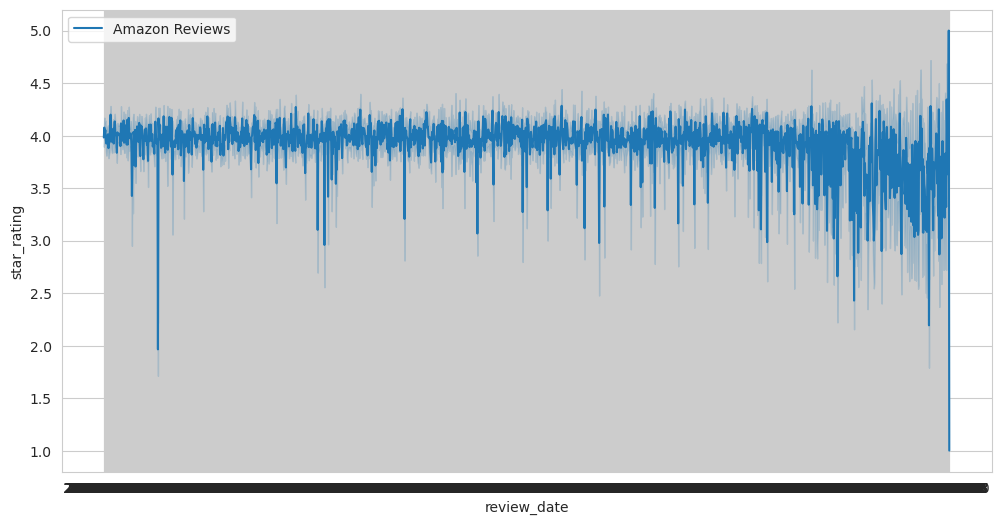

In [ ]:
# Time-Series Data Visualization & Analysis
# Graphing the amazon dataset and amazon_reviews_us by time
import matplotlib.pyplot as plt
import seaborn as sns

df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_review['timestamp'], y=df_review['rating'], label='Amazon Reviews')

In [ ]:
**Countplot of Ratings**

Text(0, 0.5, 'Count')

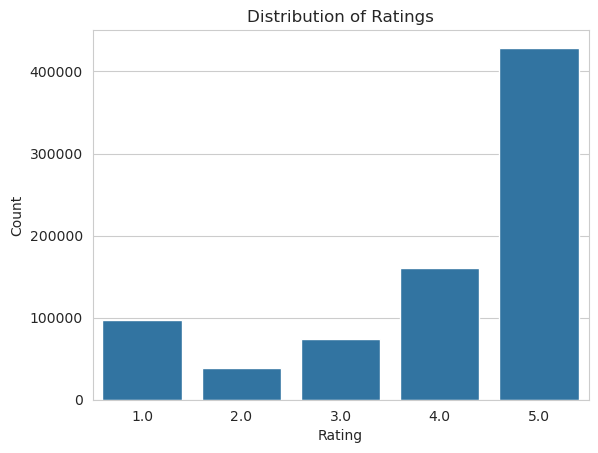

In [ ]:
sns.countplot(x='rating', data=df_review)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

In [ ]:
**Pie Chart of Ratings**

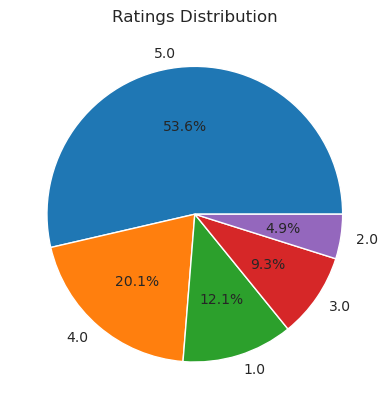

In [ ]:
df_review['rating'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Ratings Distribution')
plt.ylabel('')
plt.show()

In [ ]:
**Temporal Analysis: Reviews Over Time w/ Line Plot: Number of reviews per month**

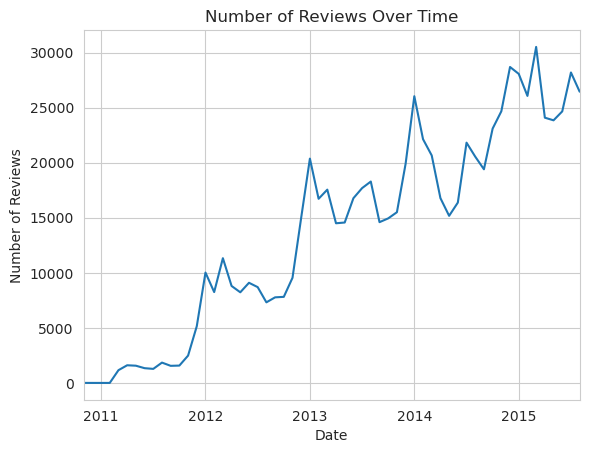

In [ ]:
df_review.set_index('timestamp', inplace=True)
df_review.resample('M').size().plot(kind='line') # 'M' = Month end frequency
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

**Average Rating Over Time**

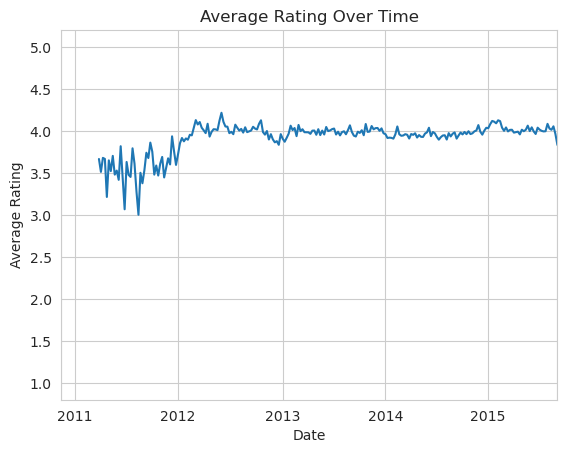

In [ ]:
df_review.resample('W')['timestamp'].mean().plot(kind='line')
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

**Textual Analysis**

**Word Cloud: Visual representation of the most frequent words in positive and negative reviews**

In [ ]:
!pip install wordcloud --quiet

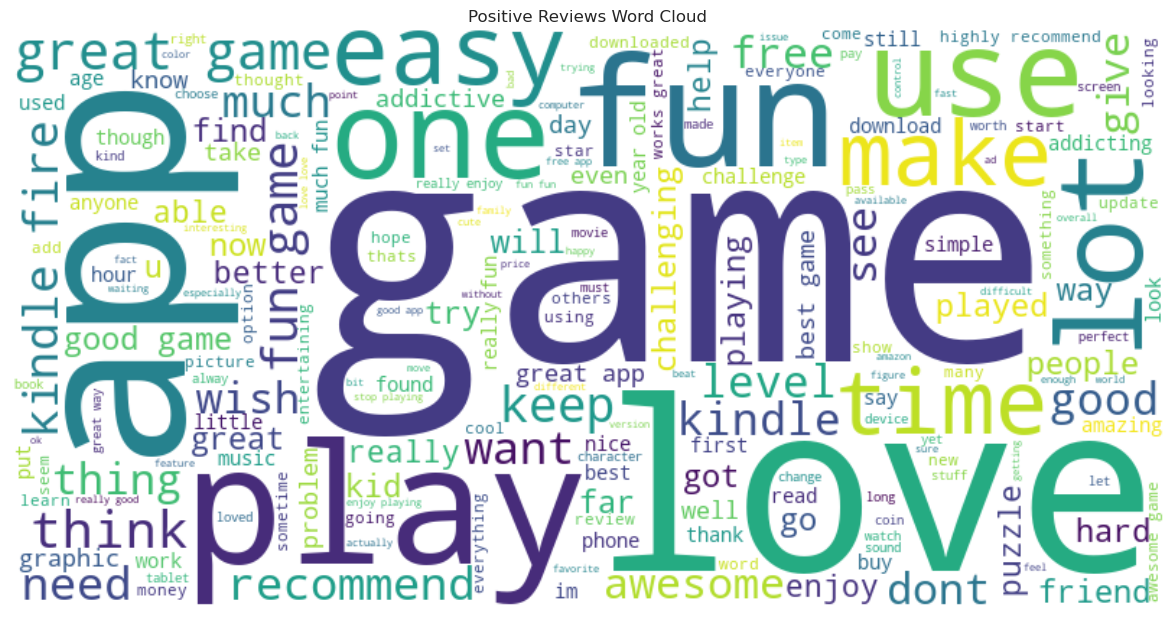

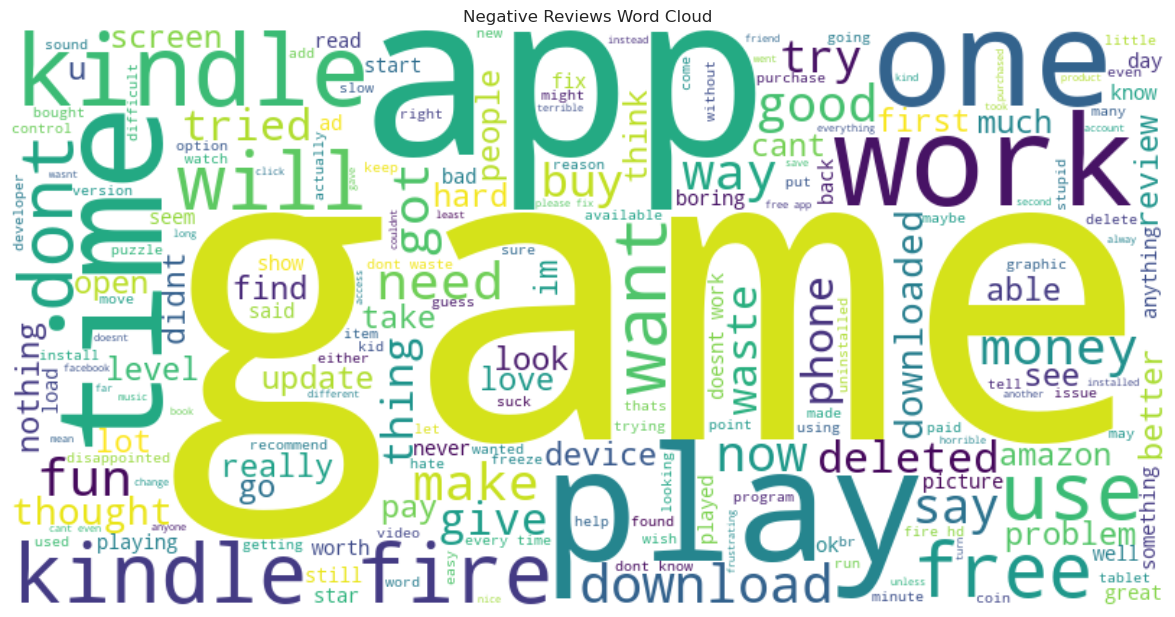

In [ ]:
from wordcloud import WordCloud

positive_reviews = ' '.join(df_review[df_review['star_rating'] >= 4]['review_body'][:100000])
negative_reviews = ' '.join(df_review[df_review['star_rating'] <= 2]['review_body'][:100000])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot Positive Word Cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

# Plot Negative Word Cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

**Top N Frequent Words**

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


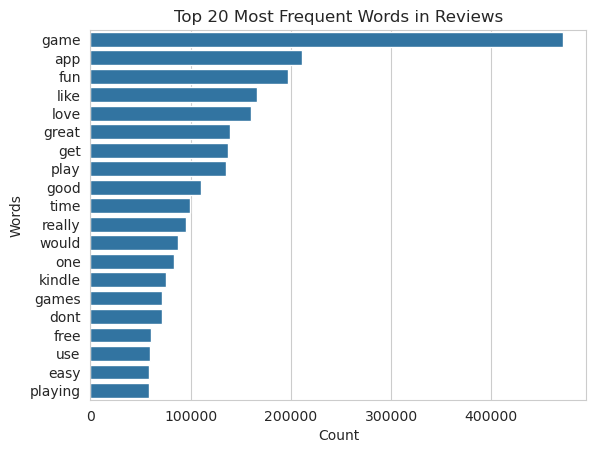

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def get_top_n_words(text_series, n=20):
    words = ' '.join(text_series).lower().split()
    words = [word for word in words if word.isalpha() and word not in stop_words]
    counter = Counter(words) # Counter creates a collection keeping track of the number of instances of each item in a dictionary with the name of each item
    return counter.most_common(n)

top_words = get_top_n_words(df_review['review_body'], 20)
words, counts = zip(*top_words)

sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Frequent Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

**Length of Reviews**

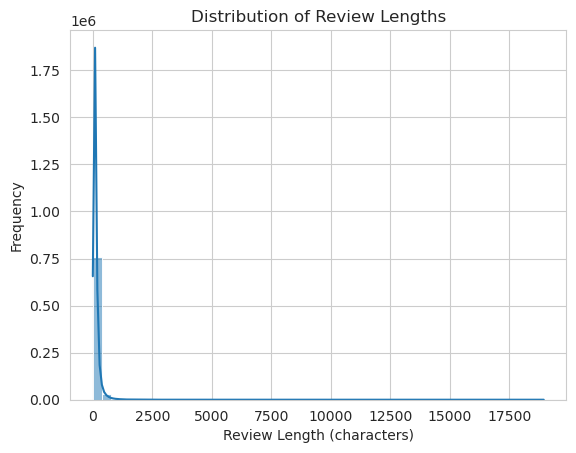

In [ ]:
df_review['review_length'] = df_review['review_body'].str.len()
sns.histplot(df_review['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

**Box Plot of Review Length by Rating:**

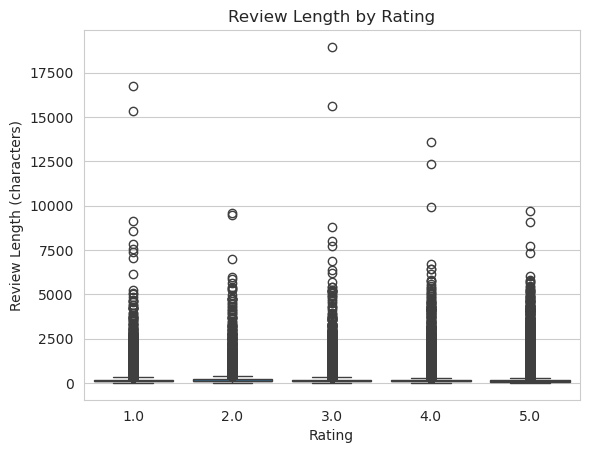

In [ ]:
sns.boxplot(x='star_rating', y='review_length', data=df_review)
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length (characters)')
plt.show()

**Top Reviewers**

In [ ]:
df_review['user_id'].head()

0    32885599.0
1    18570929.0
2    14742967.0
3    46355758.0
4     4595369.0
Name: customer_id, dtype: float64

In [ ]:
top_user_reviews = pd.DataFrame(df_review['user_id'].value_counts().head(20))
top_user_reviews

customer_id
20129932.0          130
44834233.0          117
40079136.0           89
32038204.0           88
46823467.0           86
45238443.0           84
52139318.0           83
14535682.0           80
13878853.0           76
53017806.0           71
27626904.0           66
48615551.0           60
52638514.0           60
19600101.0           58
18013496.0           57
22786060.0           56
9990648.0            54
42905320.0           51
15883707.0           50
2176877.0            49

**Bar Chart of Top 20 Customer Reviewers**

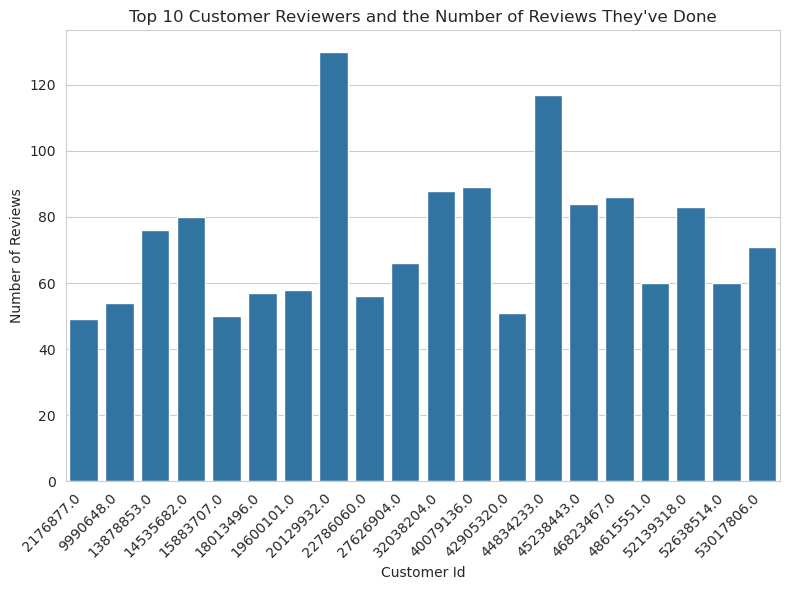

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_user_reviews.index, y=top_user_reviews['customer_id'])
plt.title("Top 10 Customer Reviewers and the Number of Reviews They've Done")
plt.xlabel('Customer Id', fontsize=10)
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [ ]:
# Prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

/tmp/ipykernel_14836/1006859298.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_train.rename(columns={'review_date': 'ds', 'star_rating': 'y'}, inplace=True)
/tmp/ipykernel_14836/1006859298.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_test.rename(columns={'review_date': 'ds', 'star_rating': 'y'}, inplace=True)
18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing


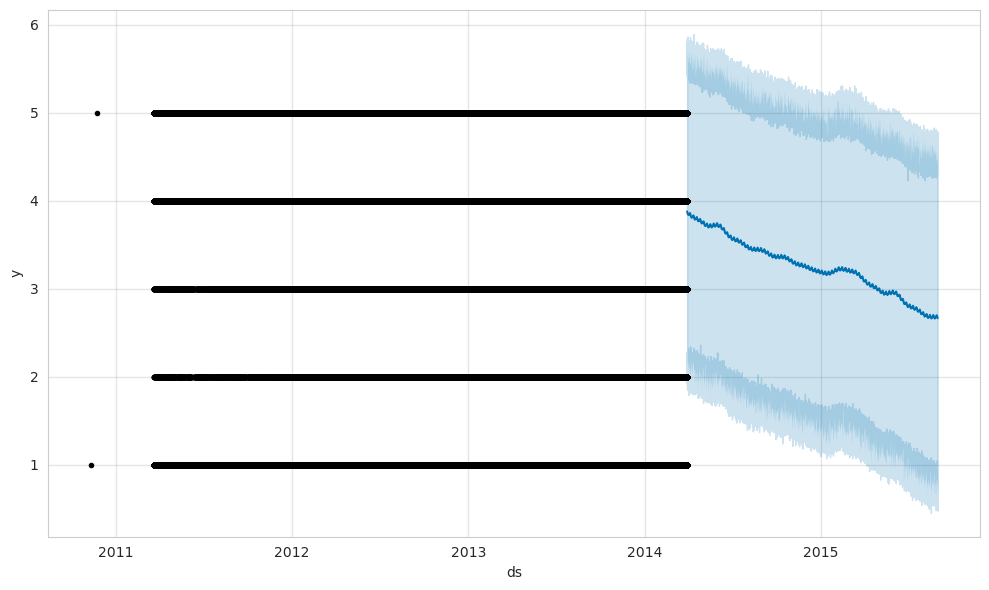

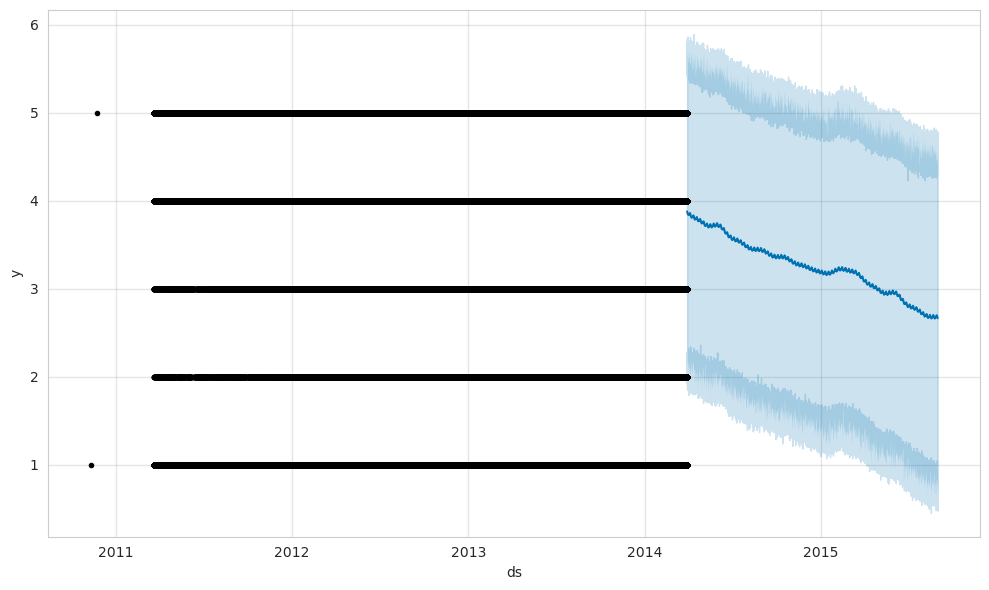

In [ ]:
# Prophet Baseline Model
# Find the median of the date column
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
median_time = df_review['timestamp'].median()

split_date = median_time

df_review_train = df_review[df_review['timestamp'] <= split_date]
df_review_test = df_review[df_review['timestmap'] > split_date]

# Rename df_review_train, df_review_test columns to 'review_date' = 'ds' and 'star rating' = y
df_review_train.rename(columns={'timestamp': 'ds', 'rating': 'y'}, inplace=True)
df_review_test.rename(columns={'timestamp': 'ds', 'rating': 'y'}, inplace=True)

prophet_baseline = Prophet()

# Fit the model
prophet_baseline.fit(df_review_train)
forecast = prophet_baseline.predict(df_review_test)
prophet_baseline.plot(forecast)

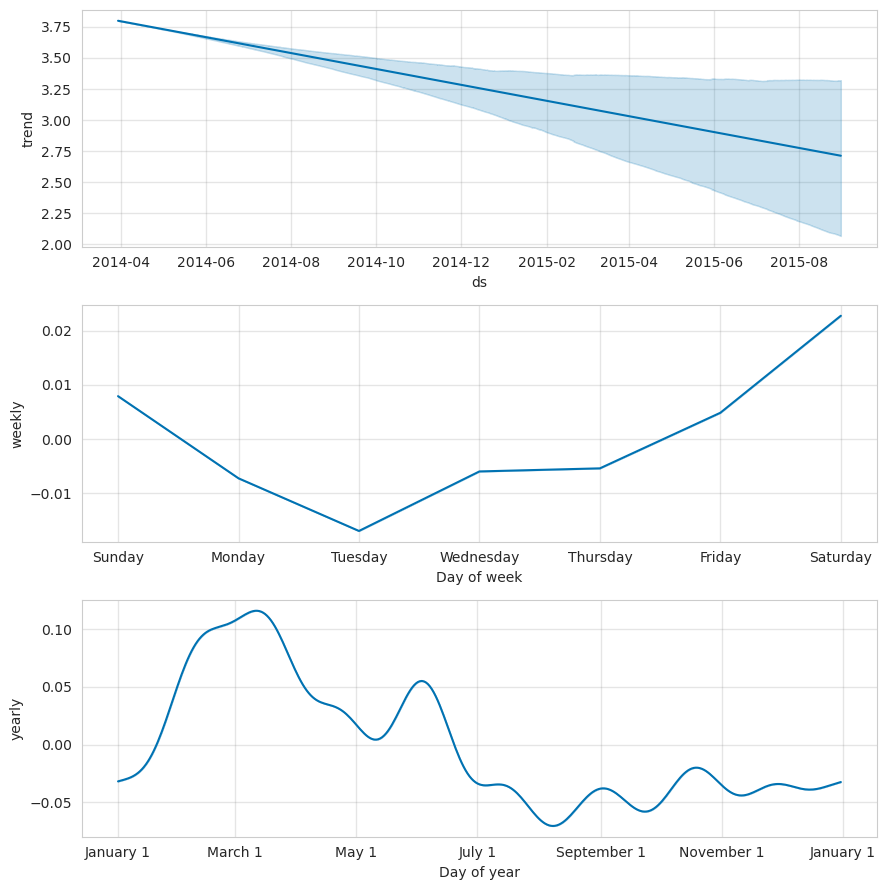

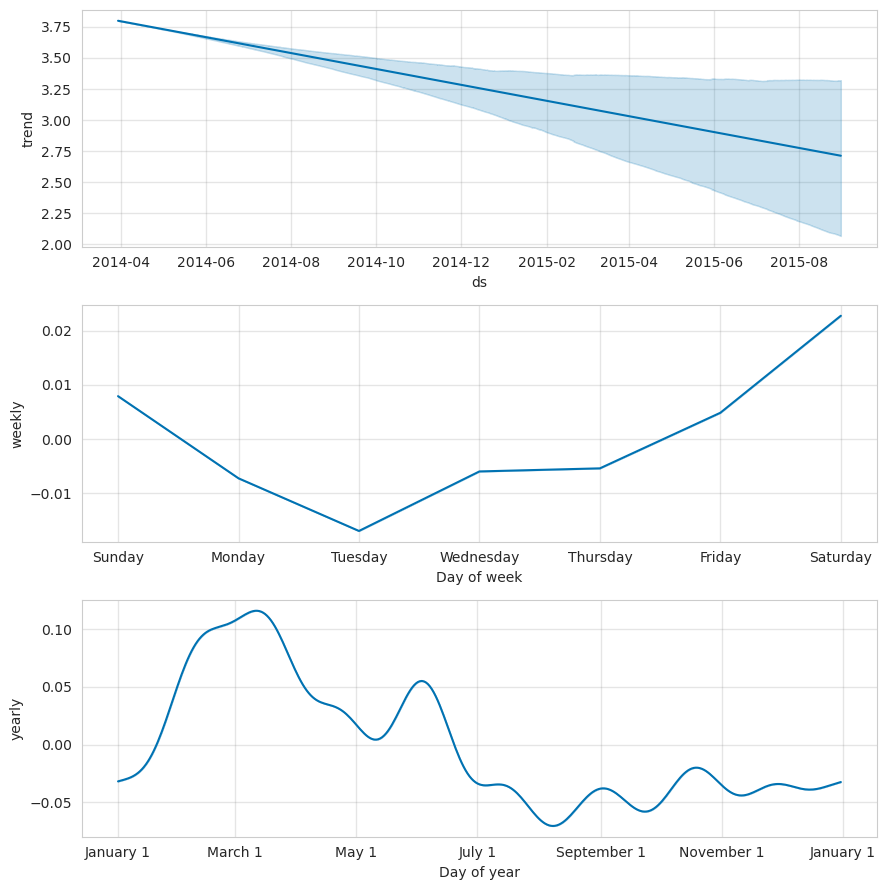

In [ ]:
prophet_baseline.plot_components(forecast)

**XGBoostClassifier Time Series Forecasting**

In [ ]:
!pip install xgboost --quiet

Accuracy: 1.000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49245
           1       1.00      1.00      1.00     18377
           2       1.00      1.00      1.00     35678
           3       1.00      1.00      1.00     76459
           4       1.00      1.00      1.00    219795

    accuracy                           1.00    399554
   macro avg       1.00      1.00      1.00    399554
weighted avg       1.00      1.00      1.00    399554



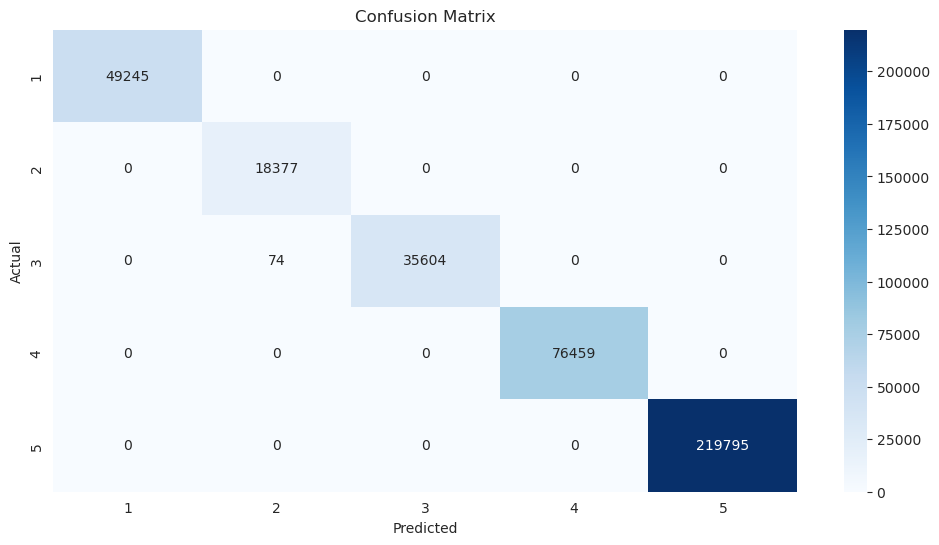

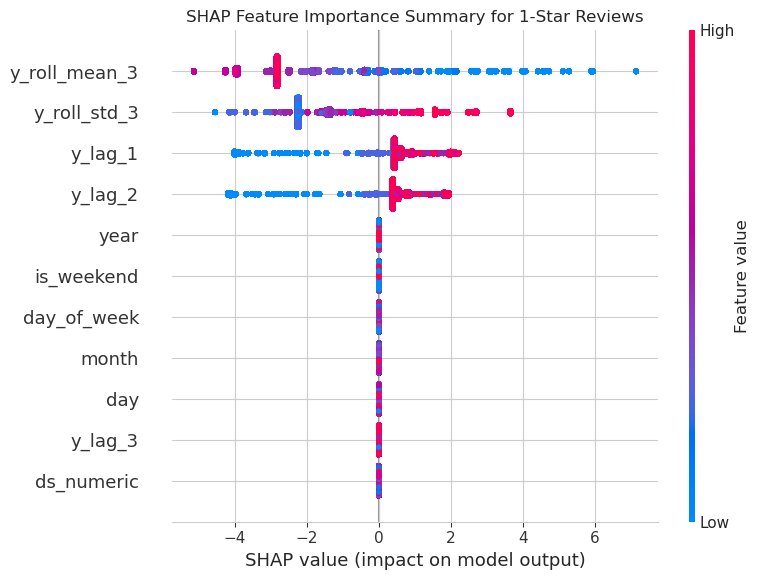

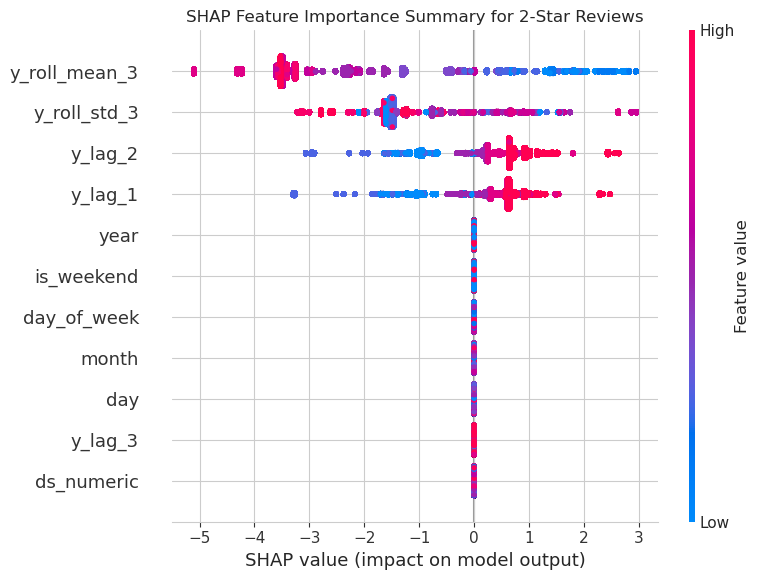

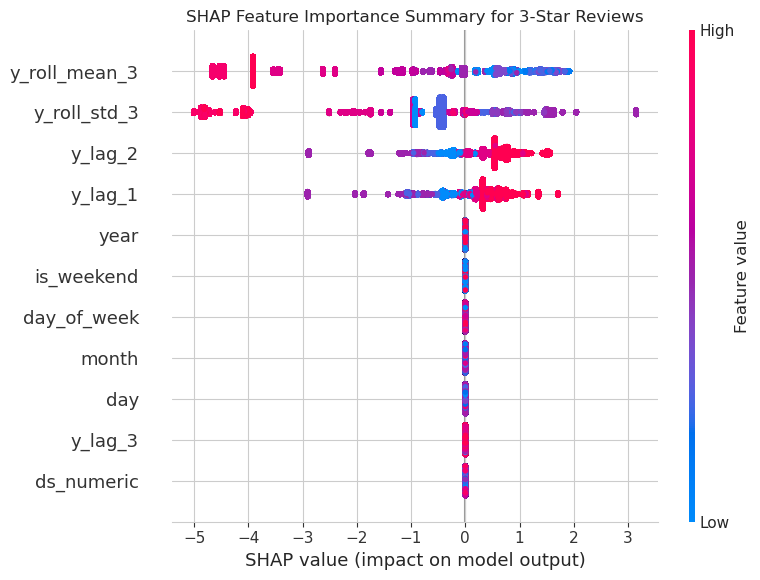

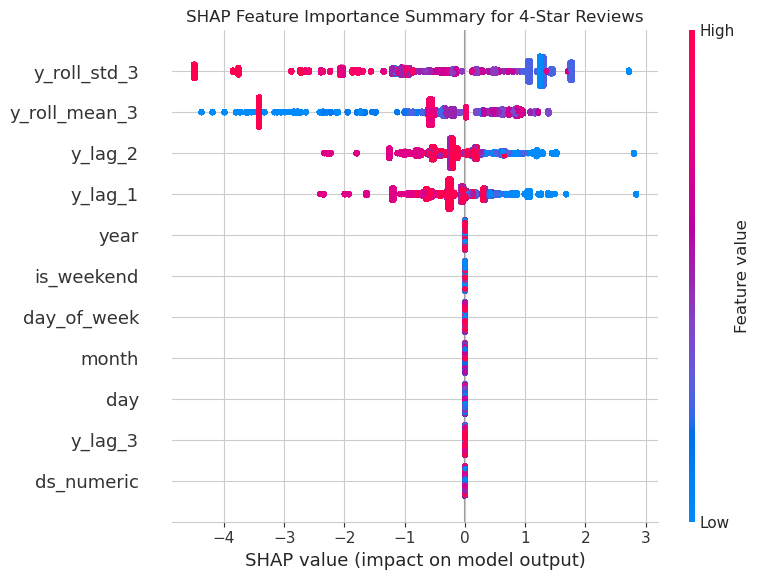

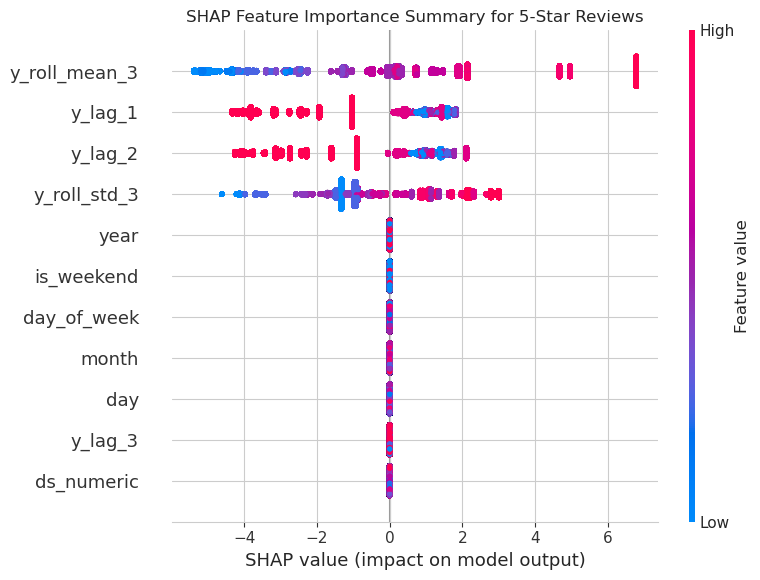

<Figure size 1000x600 with 0 Axes>

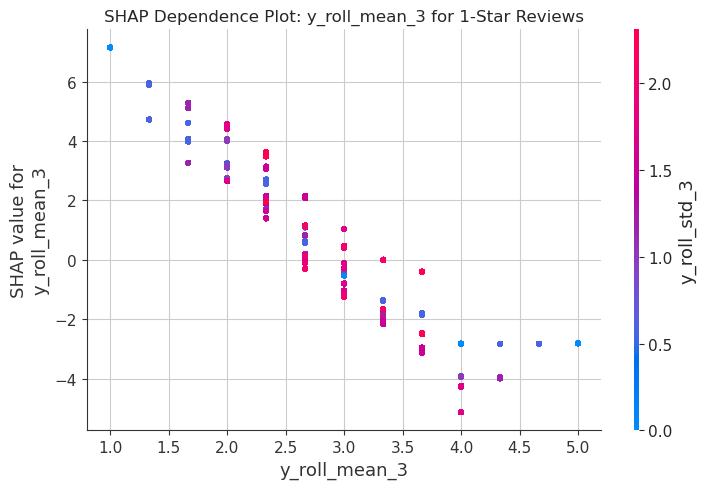

<Figure size 1000x600 with 0 Axes>

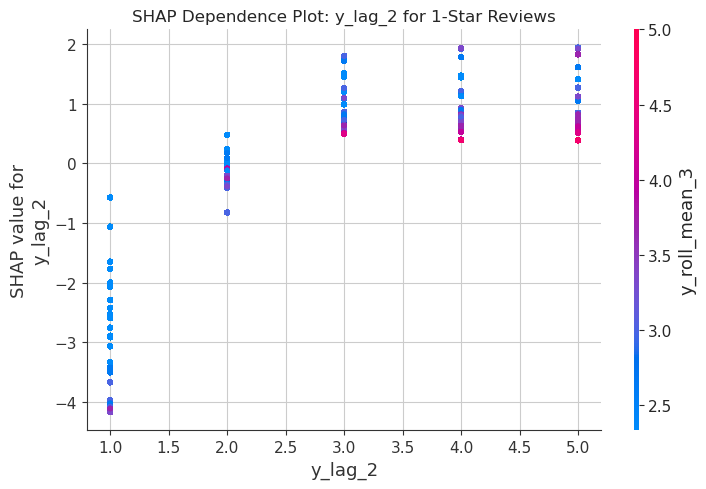

<Figure size 1000x600 with 0 Axes>

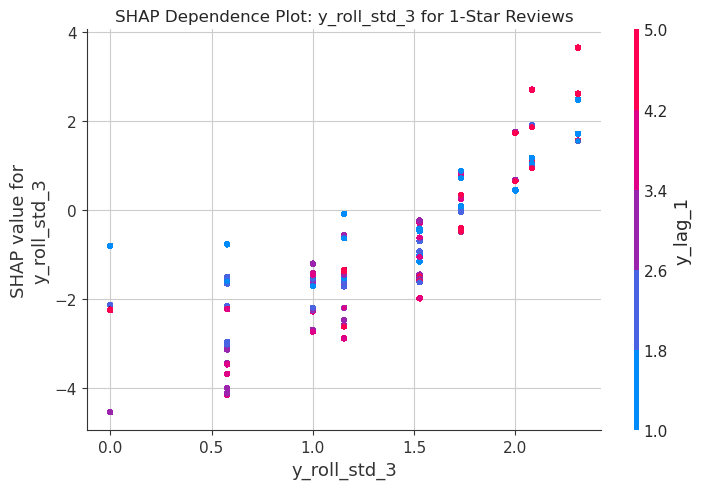

<Figure size 1000x600 with 0 Axes>

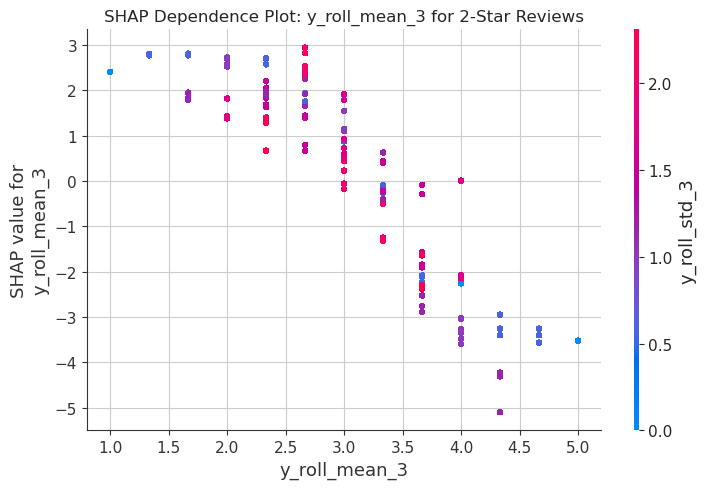

<Figure size 1000x600 with 0 Axes>

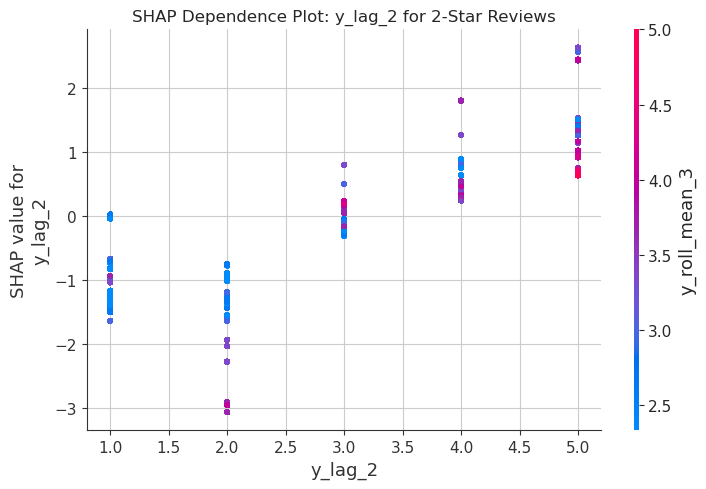

<Figure size 1000x600 with 0 Axes>

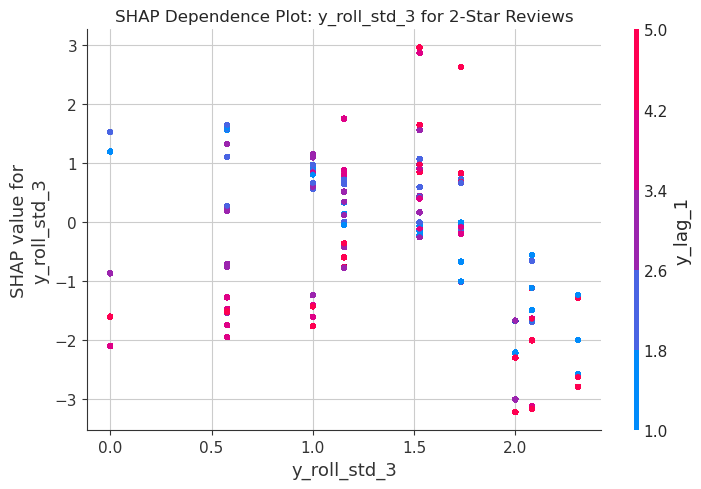

<Figure size 1000x600 with 0 Axes>

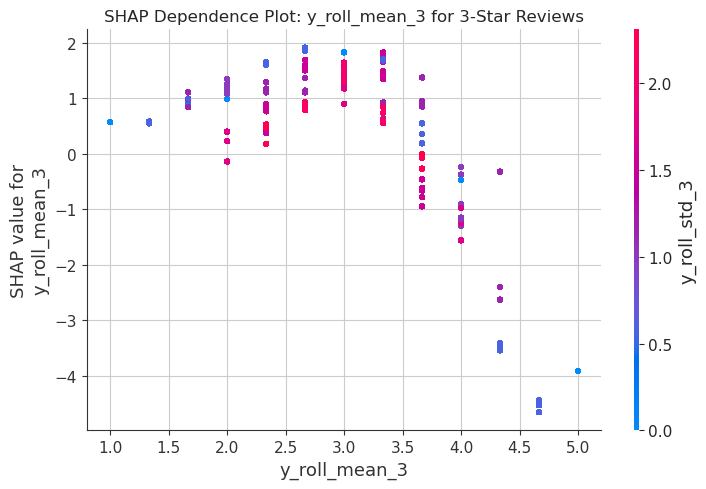

<Figure size 1000x600 with 0 Axes>

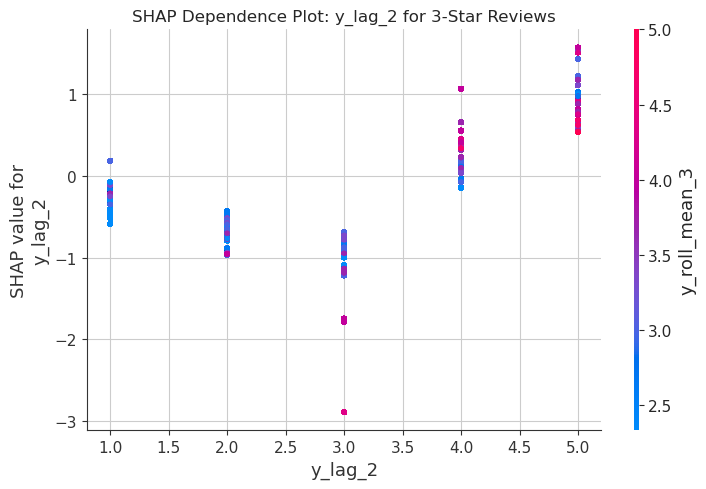

<Figure size 1000x600 with 0 Axes>

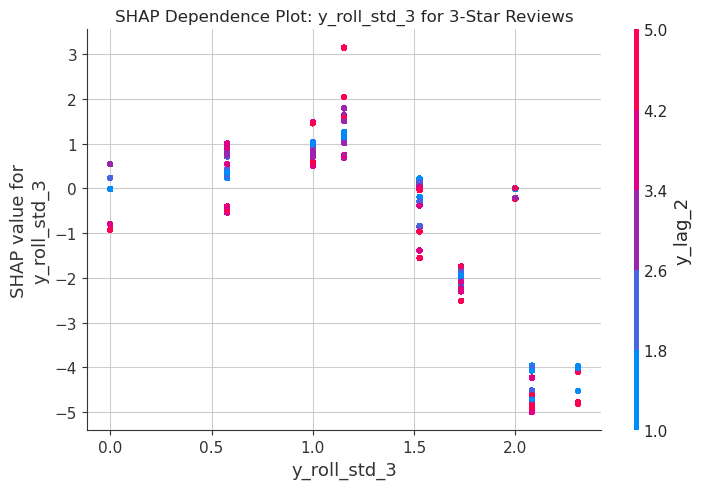

<Figure size 1000x600 with 0 Axes>

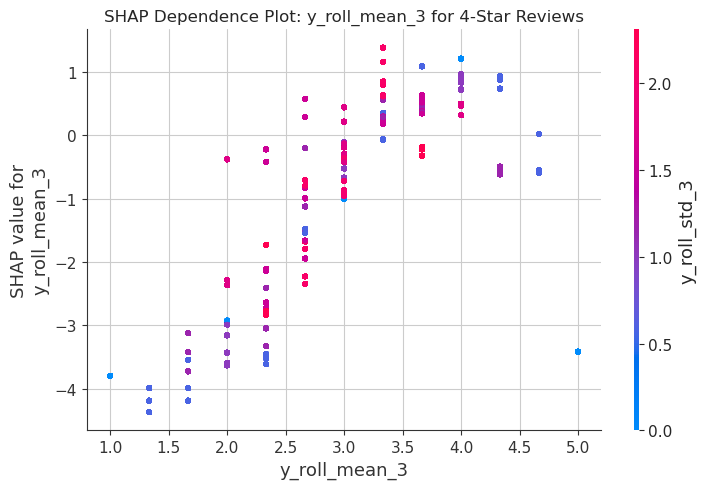

<Figure size 1000x600 with 0 Axes>

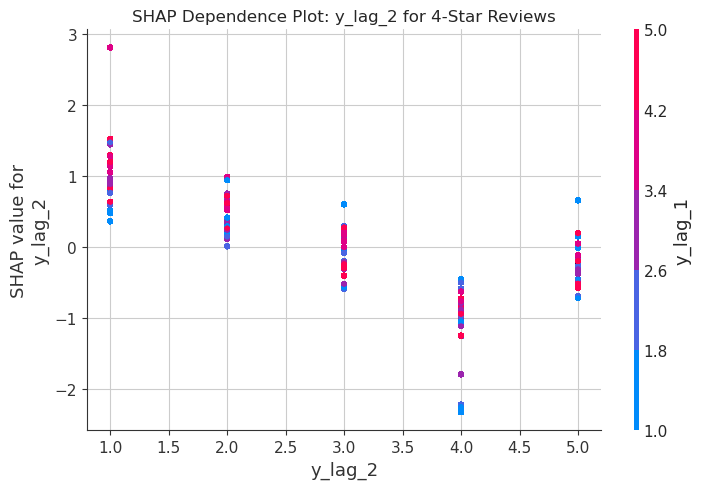

<Figure size 1000x600 with 0 Axes>

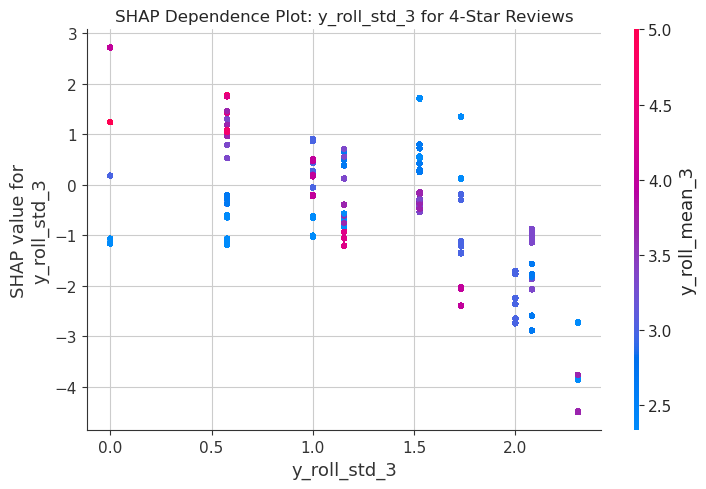

<Figure size 1000x600 with 0 Axes>

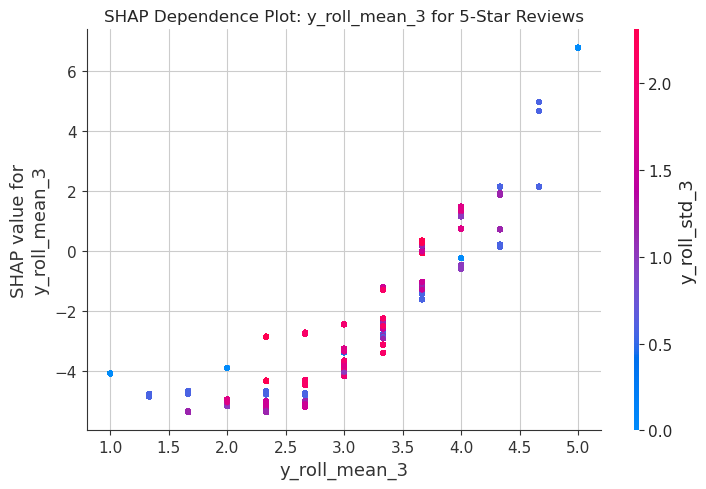

<Figure size 1000x600 with 0 Axes>

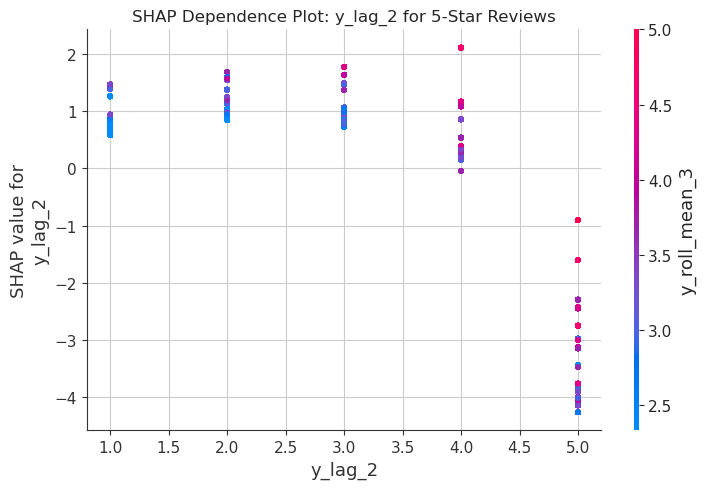

<Figure size 1000x600 with 0 Axes>

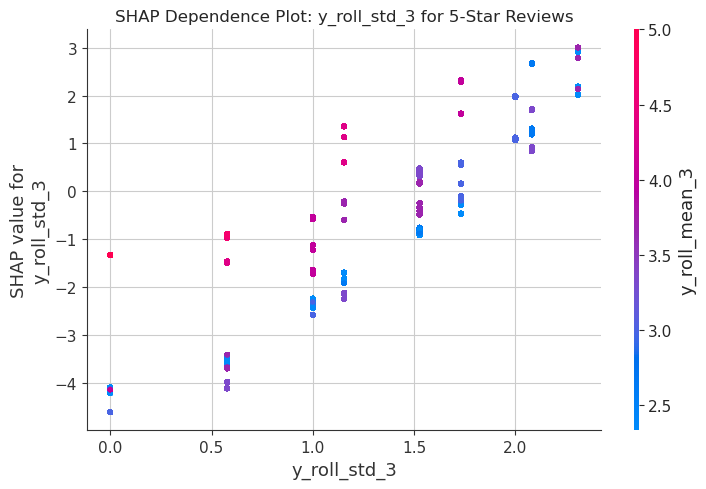

Force Plot for Review 100 (actual rating: 1 star review)


Force Plot for Review 100 (actual rating: 2 star review)


Force Plot for Review 100 (actual rating: 3 star review)


Force Plot for Review 100 (actual rating: 4 star review)


Force Plot for Review 100 (actual rating: 5 star review)


Force Plot for Review 200 (actual rating: 1 star review)


Force Plot for Review 200 (actual rating: 2 star review)


Force Plot for Review 200 (actual rating: 3 star review)


Force Plot for Review 200 (actual rating: 4 star review)


Force Plot for Review 200 (actual rating: 5 star review)


Force Plot for Review 300 (actual rating: 1 star review)


Force Plot for Review 300 (actual rating: 2 star review)


Force Plot for Review 300 (actual rating: 3 star review)


Force Plot for Review 300 (actual rating: 4 star review)


Force Plot for Review 300 (actual rating: 5 star review)


Force Plot for Review 400 (actual rating: 1 star review)


Force Plot for Review 400 (actual rating: 2 star review)

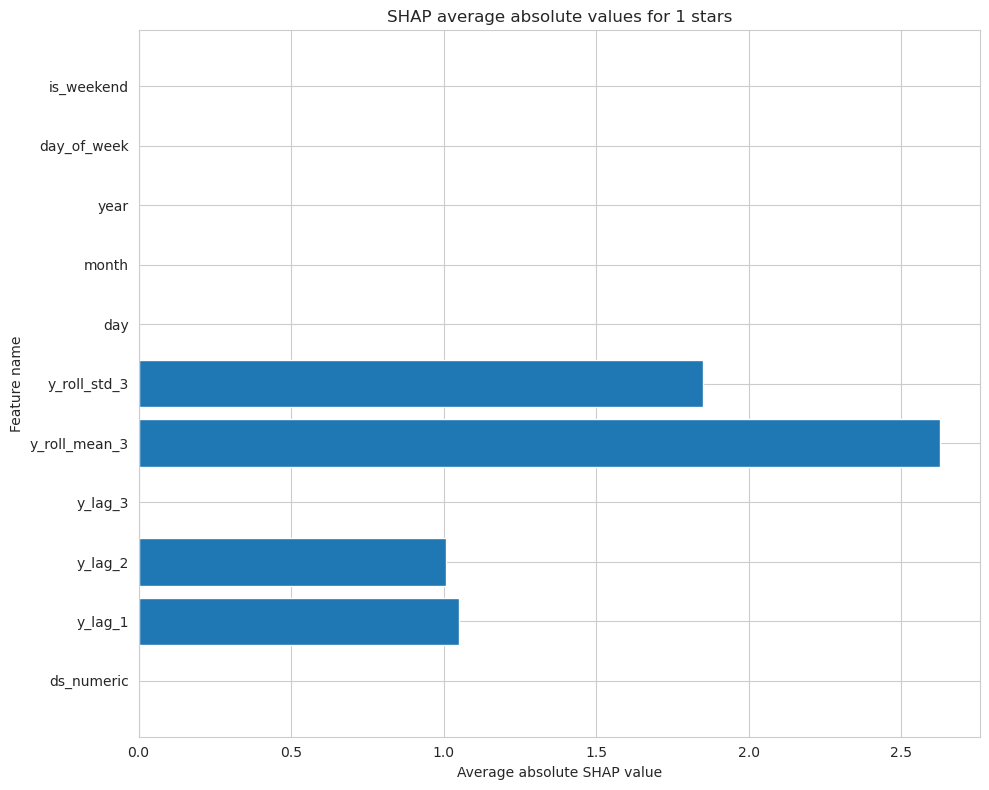

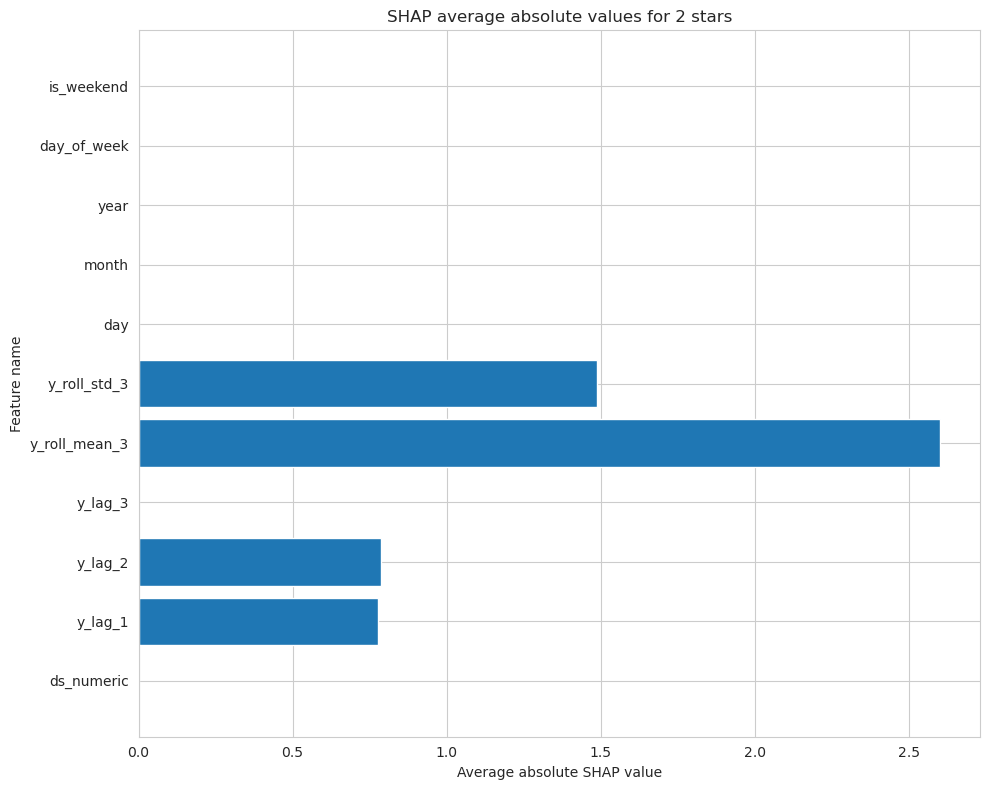

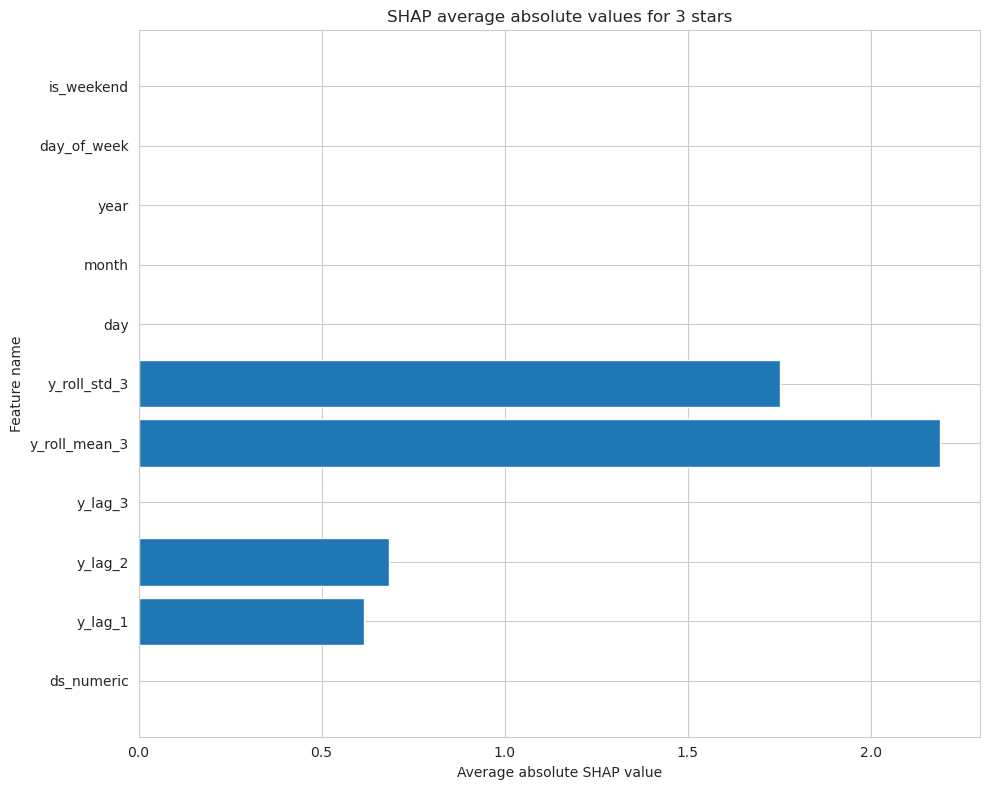

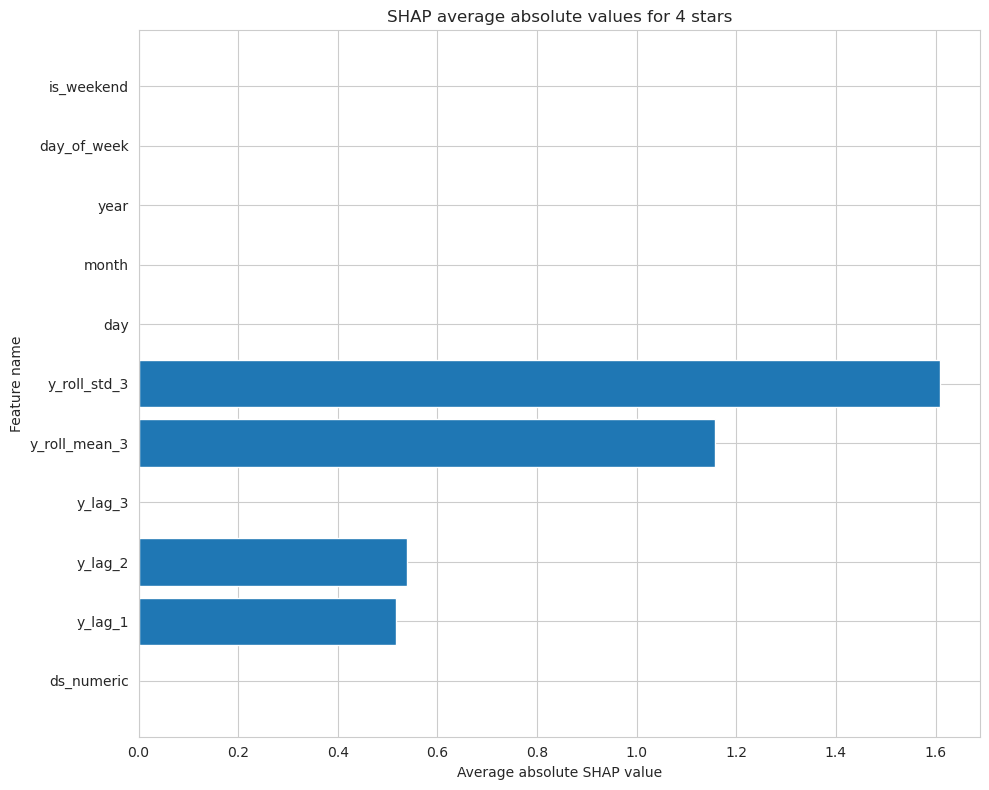

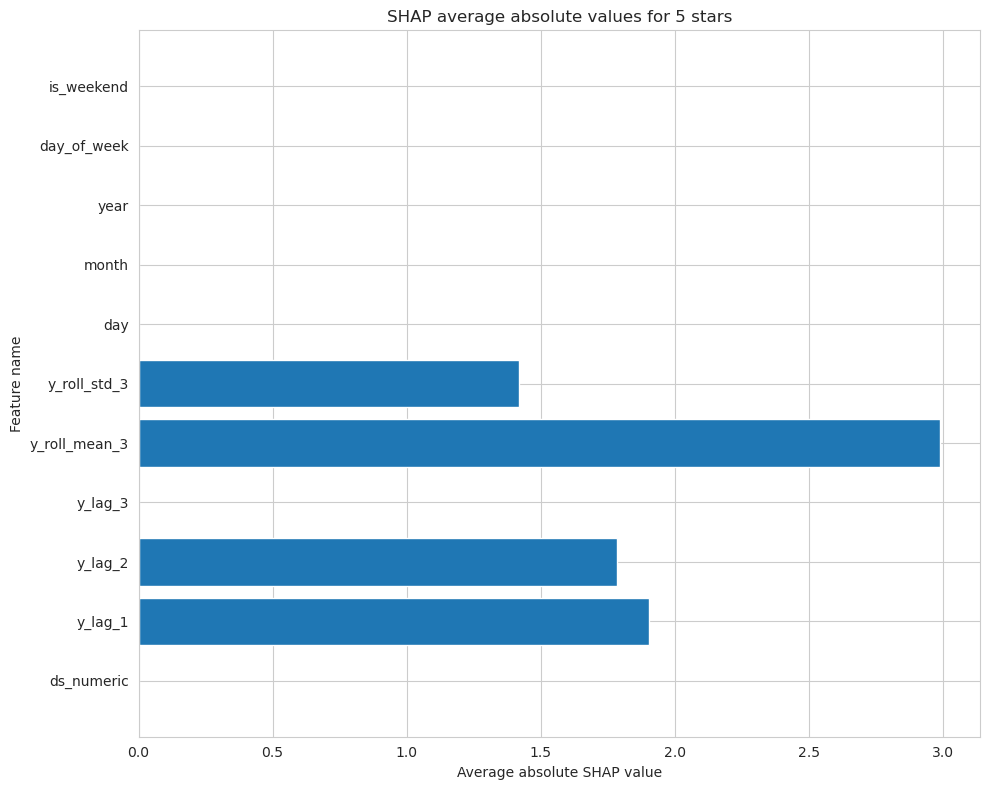

In [ ]:
# XGBoost works well for large, complex datasets by calculating pseudo residuals, sequentially having each tree learn from the mistakes of a previous tree
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

# Data Preparation
df_review_train['ds'] = pd.to_datetime(df_review_train['ds'])
df_review_test['ds'] = pd.to_datetime(df_review_test['ds'])

# Convert 'ds' to numeric (Unix timestamp)
df_review_train['ds_numeric'] = df_review_train['ds'].astype(int) / 10**9
df_review_test['ds_numeric'] = df_review_test['ds'].astype(int) / 10**9   # Divide it by 10 to the 9th power

# Ensure 'y' is an integer and within 1-5
df_review_train['y'] = df_review_train['y'].astype(int)
df_review_test['y'] = df_review_test['y'].astype(int)

# Feature Engineering
# Create lag_features functions
# "lag features" are created by taking the values of a variable from previous time points
# and using them as additional features in the current time step to predict the rating
def create_lag_features(df, lags=[1, 2, 3]):
    for lag in lags:
        df[f'y_lag_{lag}'] = df['y'].shift(lag)
    return df

# Apply lag features - essentially give more context to the XGBClassifier model for prediction
for lag in [1, 2, 3]: # 1 day before, 2 days before, 3 days before
    df_review_train = create_lag_features(df_review_train, [lag])
    df_review_test = create_lag_features(df_review_test, [lag])

# Rolling statistics
# Calculates trends in data over short periods of time
df_review_train['y_roll_mean_3'] = df_review_train['y'].rolling(window=3).mean() # Calculate the average of the last 3 days, then "move" the window by 3
df_review_train['y_roll_std_3'] = df_review_train['y'].rolling(window=3).std() # Calculate the standard deviation of the last 3 days, then "move" the window by 3
df_review_test['y_roll_mean_3'] = df_review_test['y'].rolling(window=3).mean()
df_review_test['y_roll_std_3'] = df_review_test['y'].rolling(window=3).std()

# Drop NaNs
df_review_train.dropna(inplace=True)
df_review_test.dropna(inplace=True)

# Temporal features
for df in [df_review_train, df_review_test]:
    # Day, Month, Year, day_of_week, and is_weekend allow the model to predict with far greater accuracy
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Define feature columns
feature_cols = [
    'ds_numeric', 'y_lag_1', 'y_lag_2', 'y_lag_3',
    'y_roll_mean_3', 'y_roll_std_3',
    'day', 'month', 'year', 'day_of_week', 'is_weekend'
]

X_train = df_review_train[feature_cols]
y_train = df_review_train['y']
X_test = df_review_test[feature_cols]
y_test = df_review_test['y']

# Make sure ratings are 0, 1, 2, 3, & 4 so the XGBClassifier can process them
y_train = y_train - 1
y_test = y_test - 1

# 2.) Intialize XGBClassifier
xgb_clf = XGBClassifier(
    objective='multi:softmax', # Ratings 0, 1, 2, 3, and 4 are more than two distinct classes
    num_class=5,
    num_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 3.) Train the Model
xgb_clf.fit(X_train, y_train)

# 4.) Predictions
xgb_pred = xgb_clf.predict(X_test)

# 5.) Evaluation
accuracy = accuracy_score(y_test, xgb_pred)
print(f'Accuracy: {accuracy:.3f}')

print('Classification Report:')
print(classification_report(y_test, xgb_pred))

# 6.) Confusion Matrix
conf_mat = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Convert SHAP values to a single array (if needed)
if isinstance(shap_values, list):  # In case shap_values is a list (multi-class case)
    shap_values = np.sum(shap_values, axis=0)

# Feature importance summary plot (beeswarm plot)
# Define the different ratings.
ratings = [1, 2, 3, 4, 5]

# -------------------------------------------------------------
# 1. Separate Summary Plots for Each Rating
# -------------------------------------------------------------
for rating in ratings:
    # Select shap values for the current rating (e.g. selecting index 0, 1, 2, 3, 4)
    selected_shap_values = shap_values[:,:, rating - 1] # index is rating-1

    # Feature importance summary plot (beeswarm plot)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(selected_shap_values, features=X_test, feature_names=feature_cols, show=False)
    plt.title(f"SHAP Feature Importance Summary for {rating}-Star Reviews")
    plt.tight_layout()  # Adjust layout for labels
    plt.show()

# -------------------------------------------------------------
# 2. Dependence Plots for Key Features
# -------------------------------------------------------------
# Select the specific features to analyze
key_features = ['y_roll_mean_3', 'y_lag_2', 'y_roll_std_3']  # Replace with actual column names
for rating in ratings:
    for feature in key_features:
         # Select shap values for the current rating (e.g. selecting index 0, 1, 2, 3, 4)
        selected_shap_values = shap_values[:,:, rating-1] #index is rating -1
        feature_index = feature_cols.index(feature) # find the index of our feature

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_index,
            selected_shap_values,
            X_test,
            feature_names=feature_cols,
            show = False #we show the graphs later.
        )
        plt.title(f"SHAP Dependence Plot: {feature} for {rating}-Star Reviews")
        plt.tight_layout() #adjust layout to avoid label overlap
        plt.show()


# -------------------------------------------------------------
# 3. Force Plots for Individual Reviews (Example)
# -------------------------------------------------------------
# Select specific review indices to showcase. Make sure that they are different reviews
review_indices = [100, 200, 300, 400, 500]  # Example reviews
for index in review_indices:
    # Select the individual review to analyze
    individual_review = X_test[index:index+1]
    #Select the shap values for all the reviews
    all_shap_values_for_review = shap_values[index:index+1]

    for rating in ratings: #loop through all of the ratings
        # Select shap values for the current rating (e.g. selecting index 0, 1, 2, 3, 4)
        selected_shap_values_for_review = all_shap_values_for_review[:,:,rating-1]

        #Display the force plot for the review
        shap.force_plot(
            explainer.expected_value[rating-1], # this assumes that the explainer has the expected values, if not, you must use a model or calculate a value from the training data.
            selected_shap_values_for_review,
            individual_review,
            feature_names=feature_cols,
            show = True #show the graph after each one
        )
        #print the review rating
        print(f"Force Plot for Review {index} (actual rating: {ratings[rating-1]} star review)")
        print('\n')

# -------------------------------------------------------------
# 4. Bar Plot of average absolute SHAP value of each feature
# -------------------------------------------------------------
for rating in ratings:
    # Select shap values for the current rating (e.g. selecting index 0, 1, 2, 3, 4)
    selected_shap_values = shap_values[:,:, rating - 1]  # index is rating -1

    # Calculate the average absolute SHAP value for each feature
    mean_abs_shap = np.mean(np.abs(selected_shap_values), axis = 0)

    # Plot the bar plot
    plt.figure(figsize = (10, 8))
    plt.barh(feature_cols, mean_abs_shap) #create a bar graph
    plt.xlabel("Average absolute SHAP value")
    plt.ylabel("Feature name")
    plt.title(f"SHAP average absolute values for {rating} stars")
    plt.tight_layout()  # Adjust layout to avoid labels overlapping.
    plt.show()

In [ ]:
shap_values_class_0 = shap_values[:, :, 0]

# Now shap_values_class_0 should have shape (399566, 11)
print("shape of shap_values_class_0", shap_values_class_0.shape)

shape of shap_values_class_0 (399566, 11)
